In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
from scipy.stats import zscore, spearmanr, rankdata
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 5]

import os
import sys
sys.path.append('../')
from alpha_191 import Alpha191

import warnings
warnings.filterwarnings('ignore')

import feather

### 读取自存数据

In [ ]:
universe = feather.read_dataframe('bitcoin_data/raw36_20220301_20230527.feather')
universe = universe.drop(columns=['close time'])
universe['date'] = pd.to_datetime(universe['date'],format='%Y-%m-%d %H:%M:%S')
universe = universe.set_index(['date']).sort_values(by=['date', 'ts_code'])

In [ ]:
universe['vwap'] = universe['amount']/universe['volume']
universe = universe.rename(columns={'open':'open_usdt', 'high':'high_usdt', 'low':'low_usdt', 
                                    'close':'close_usdt', 'vwap':'vwap_usdt'})

In [ ]:
def my_groupby(df, column, func, sort_keys=['date', 'ts_code']):
    all_df = pd.DataFrame()
    for val in tqdm(df[column].unique()):
        tmp = df.loc[df[column] == val]
        all_df = all_df.append(func(tmp))
    return all_df.sort_index(level=sort_keys)

In [ ]:
def convert_price_to_returns(df):
    def cal_(data):
        data['close'] = data['close_usdt'].pct_change()
        data['close'] = (data['close'].fillna(0) + 1).cumprod()
        data['vwap'] = data['vwap_usdt'].pct_change()
        data['vwap'] = (data['vwap'].fillna(0) + 1).cumprod()
        
        for feature in ['open', 'high', 'low',]:
            data[feature] = data[feature + '_usdt']/data['close_usdt'] * data['close']
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = convert_price_to_returns(universe)

In [ ]:
universe['trade_date'] = universe.index

In [ ]:
universe.loc[(universe.ts_code=='BTCUSDT')][['vwap', 'close']].plot(grid=True)

### 构造指数

### 读取网盘数据
选取2021-04 至 2023-03月数据 频率为4H

In [ ]:
folder_path = 'bitcon/tlkjdata/'  # 替换为实际的文件夹路径

file_list = []  # 存储文件的列表

# 遍历文件夹下的所有文件
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)  # 构建文件的完整路径
    if os.path.isfile(file_path):  # 确保当前路径是文件而不是文件夹
        file_list.append(file_path)  # 将文件路径添加到列表中

In [ ]:
def sum_volume(series):
    return series.sum()

universe = pd.DataFrame()
for path in tqdm(file_list):
    df = feather.read_dataframe(path)
    df = df.rename(columns={'vol':'volume'})
    df[['open','close','high','low','volume']] = df[['open','close','high','low','volume']].astype(np.float32)
    half_day_data = df.set_index(['date']).resample('2H').agg({
                    'open':'first', 'high':'max', 'low':'min', 'close':'last', 'volume':sum_volume})
    start_time = pd.to_datetime('2022-01-01')
    end_time = pd.to_datetime('2023-03-28')
    half_day_data = half_day_data[(half_day_data.index >= start_time) & (half_day_data.index <= end_time)]
    exist_time = (end_time - half_day_data.index[0]).days
    if exist_time <= 260:
        continue
    half_day_data['ts_code'] = path.split('_')[0].split('/')[2]
    universe = universe.append(half_day_data)

In [ ]:
universe['vwap'] = (universe['low'] + universe['high'] + universe['close'])/3
universe['trade_date'] = universe.index
#universe = universe.loc[universe['trade_date']<='2023-03-29']

In [ ]:
bak = universe.copy(deep=True)
bak

### 构造技术指标为alpha

In [ ]:
import stockstats

class IndicatorHelper(pd.DataFrame):
    """
        add indicators to dataframe
    """

    def __init__(self, data):
        super(IndicatorHelper, self).__init__(data)

        self.stocks = stockstats.StockDataFrame.retype(data.copy())
        self.df = self

    def add_technical_indicator(self, tech_indicator_list):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param ticker: (df) pandas dataframe
        :param tech_indeicator_list list
        :return: (df) pandas dataframe
        """
        unique_ticker = self.df.ts_code.unique()

        indicator_df = pd.DataFrame()
        for i in tqdm(range(len(unique_ticker)), desc='add tech indicators'):
            temp_indicator = self.stocks[self.stocks.ts_code == unique_ticker[i]]
            temp_indicator = temp_indicator[tech_indicator_list + ['ts_code', 'trade_date']]
            indicator_df = indicator_df.append(temp_indicator, ignore_index=True)
        
        self.df = self.df.merge(indicator_df, on=["ts_code", "trade_date"], how="left")
        self.df['date'] = self.df['trade_date'].apply(lambda x: pd.Timestamp(x))
        self.df = self.df.set_index(['date']).sort_values(by=['date', 'ts_code'])
        return self.df
    

In [ ]:
# add tech indicators
tech_indicator_list = ['log-ret','atr_5', 'close_10_kama_5_30', 'close_10_kama_2_30', 'wt1', 'wt2',
                      'ppo', 'stochrsi_6', 'cci_6', 'rsi_6', 'supertrend'] 
universe = IndicatorHelper(universe).add_technical_indicator(tech_indicator_list)

In [ ]:
universe['alpha_kama2'] = universe['close_10_kama_2_30']
universe['alpha_atr'] = -universe['atr_5']
universe['alpha_wt'] = universe['wt1'] - universe['wt2']
universe['alpha_wtr'] = universe['wt1']
universe['alpha_cci'] = universe['cci_6']
universe['alpha_srsi'] = universe['stochrsi_6']
universe['alpha_rsi'] = universe['rsi_6']
universe['alpha_ppo'] = universe['ppo']
universe['alpha_supertrend'] = (universe['close'] - universe['supertrend'])

In [ ]:
def alpha_kama(df):
    feature = 'close_10_kama_5_30'
    def cal_(df):
        kama_filter = df[feature].rolling(14).std()
        cond_in1 = (df[feature] - df[feature].shift(1)) >kama_filter
        cond_in2 = (df[feature].shift(1) - df[feature].shift(2)) > kama_filter
        cond_out1 = (df[feature] - df[feature].shift(1)) < -kama_filter
        cond_out2 = (df[feature].shift(1) - df[feature].shift(2)) < -kama_filter
        df['alpha_kama'] = np.where((cond_out1 & cond_out2), -df['close'] , - 0.3*kama_filter)
        df['alpha_kama'] = np.where((cond_in1 & cond_in2), df['close'] , df['alpha_kama'])
        
        return df
    
    df_all = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(), desc='alpha_kama processing...'):
        tmp = df.loc[df.ts_code == ts_code]
        tmp = cal_(tmp)
        df_all = df_all.append(tmp)
    return df_all.sort_values(by=['date', 'ts_code'])

#universe = universe.drop(columns=['alpha_kama'])
universe = alpha_kama(universe)

In [ ]:
def Corr(data, win_len):
    obj = data.rolling(window=win_len, method='table')
    s = []
    for o in obj:
        if o.shape[0] < win_len:
            s.append(0.)
        else:
            s.append(spearmanr(o.iloc[:, 0], o.iloc[:, 1])[0])
            # s.append(o.iloc[:, 0].corr(o.iloc[:, 1]))
    return pd.DataFrame(s, index=data.index, columns=['corr'])

def delta(df, period=1):
    return df.diff(period)

def ts_rank(data, window=10):
    return data.rolling(window).apply(lambda x: rankdata(x)[-1])

def sma(df, window=10):
    return df.rolling(window).mean()

def ESma(sr, n, m):
    return sr.ewm(alpha=m / n, adjust=False).mean()

def Regbeta(sr, x):
    window = len(x)
    return sr.rolling(window).apply(lambda y: np.polyfit(x, y, deg=1)[0])

def Sequence(n):
    return np.arange(1, n + 1)

def Decaylinear(sr, window):
    weights = np.array(range(1, window + 1))
    sum_weights = np.sum(weights)
    return sr.rolling(window).apply(lambda x: np.sum(weights * x) / sum_weights)

def my_groupby(df, column, func, sort_keys=['date', 'ts_code']):
    all_df = pd.DataFrame()
    for val in tqdm(df[column].unique()):
        tmp = df.loc[df[column] == val]
        all_df = all_df.append(func(tmp))
    return all_df.sort_values(by=sort_keys)

In [ ]:
def alpha_t1(df):
    def cal_(data):
        #wave = data['high'].rolling(4).max() - data['low'].rolling(4).min()
        data['alpha_t1'] = (data['close'].rolling(4).mean() \
                            - data['close'].rolling(14).mean())/data['close'].rolling(14).std()
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    df['alpha_t1'] = df['alpha_t1'] + 0.2 * df['rsi_6']
    return df

universe = alpha_t1(universe)

In [ ]:
def alpha_t2(df):
    def cal_(data):
        data['alpha_t2'] = data['log-ret'].rolling(4).sum()/(data['high'] - data['low']).rolling(6).sum()
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t2(universe)

In [ ]:
def alpha_t3(df):
    def cal_(data):
        wave = data['high'].rolling(12).max() - data['low'].rolling(12).min()
        data['alpha_t3'] = (data['close'] - data['low'].rolling(4).mean())/wave
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t3(universe)

In [ ]:
def alpha_t4(df): #
    # -1 * sma(ts_rank(rank(self.low), 9)) * sma(rank(close),6)
    def cal1_(data):
        data['alpha_t4'] = data['low'].rolling(12).apply(lambda x: rankdata(x)[-1])
        #data['close_r'] = data['close'].rolling(120).apply(lambda x: x.rank(pct=True)[-1])
        data['alpha_t4'] = -data['alpha_t4'].rolling(4).mean() * data['close_r']
        return data
    
    df['close_r'] = df.groupby('ts_code')['close'].apply(lambda x: x.rolling(4).mean())
    df['close_r'] = df.groupby('trade_date')['close_r'].rank(pct=True)
    df = my_groupby(df, 'ts_code', cal1_)
    df = df.drop(columns=['close_r'])
    return df

universe = alpha_t4(universe)

In [ ]:
def alpha026(df):
    ####((((SUM(CLOSE, 7) / 7) - CLOSE)) + ((CORR(VWAP, DELAY(CLOSE, 5), 230))))###
    def cal_(df):
        df['section1'] = df['close'].rolling(7).mean() - df['close']
        df['section2'] = df['close'].shift(5)
        df['section2'] = Corr(df[['vwap', 'section2']], 20)
        df['alpha_026'] = df['section1'] + df['section2']
        return df

    df = my_groupby(df, 'ts_code', cal_)
    df = df.drop(columns=['section1', 'section2'])
    return df

universe = alpha026(universe) 

In [ ]:
def alpha016(df):
    ####(-1 * TSMAX(RANK(CORR(RANK(VOLUME), RANK(VWAP), 5)), 5))###
    def cal_(data):
        data['section1'] = (data['volume'] - data['volume'].shift(1))/data['volume'].shift(1)
        return data
    df = my_groupby(df, 'ts_code', cal_)
    df[['section1', 'section2']] = df.groupby('trade_date')[['section1', 'vwap']].rank(method='min', pct=True)    
    df_all = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(), desc='alpha016 processing...'):
        tmp = df.loc[df.ts_code == ts_code]
        tmp['alpha_016'] = -Corr(tmp[['section1', 'section2']], 6)['corr']
        df_all = df_all.append(tmp)
        
    df_all = df_all.drop(columns=['section1', 'section2']).sort_values(by=['date', 'ts_code'])
    return df_all

universe = alpha016(universe) 

In [ ]:
alpha = Alpha191(universe, None, True)

In [ ]:
universe = alpha.alpha007(alpha.df)

In [ ]:
universe = alpha.alpha009(alpha.df)

In [ ]:
universe = alpha.alpha010(alpha.df)

In [ ]:
universe = alpha.alpha012(alpha.df)

In [ ]:
universe = alpha.alpha015(alpha.df)

In [ ]:
universe = alpha.alpha017(alpha.df)

In [ ]:
universe = alpha.alpha018(alpha.df)

In [ ]:
universe = alpha.alpha019(alpha.df)

In [ ]:
def alpha021(df):
    def cal_(df):
        df['alpha_021'] = Regbeta(df['close'].rolling(6).mean(), Sequence(6))
        return df

    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha021(universe) 
alpha.df = universe.copy(deep=True)

In [ ]:
def alpha029(df):
    def cal_(df):
        df['alpha_029'] = (df['close'] - df['low'].shift(3))/(df['volume'].rolling(3).mean())
        return df
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha029(universe) 
alpha.df = universe.copy(deep=True)

In [ ]:
universe = alpha.alpha022(alpha.df)

In [ ]:
universe = alpha.alpha028(alpha.df)

In [ ]:
universe = alpha.alpha040(alpha.df)

In [ ]:
universe = alpha.alpha044(alpha.df)

In [ ]:
def alpha077(df):
    def cal_(df):
        df['alpha_077'] = (df['high'] + df['low']) / 2 - df['vwap']
        df['alpha_077'] = Decaylinear(df['alpha_077'], 12)
        return df
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha077(universe) 
alpha.df = universe.copy(deep=True)

In [ ]:
universe = alpha.alpha078(alpha.df)

In [ ]:
universe = alpha.alpha083(alpha.df)

In [ ]:
universe = alpha.alpha089(alpha.df) #

In [ ]:
universe = alpha.alpha101(alpha.df)

In [ ]:
universe = alpha.alpha110(alpha.df) #

In [ ]:
universe = alpha.alpha111(alpha.df)

In [ ]:
universe = alpha.alpha112(alpha.df)

In [ ]:
universe = alpha.alpha122(alpha.df) #

In [ ]:
universe = alpha.alpha176(alpha.df) #

In [ ]:
universe = alpha.alpha190(alpha.df) #

In [ ]:
alpha.df = universe.copy(deep=True)
bak = universe.copy(deep=True)

In [ ]:
universe.columns

In [ ]:
#universe.to_csv('factor_data/final_bitcon.csv')
universe.reset_index().to_feather('bitcoin_data/factors_20220301_20230527.feather')

In [3]:
universe = pd.read_feather('bitcoin_data/factors_20220301_20230527.feather')
universe = universe.set_index(['date']).sort_values(by=['date', 'ts_code'])
universe = universe.loc[universe.index<='2023-05-25 23:00:00']
universe.shape

(363909, 69)

### 因子评估

In [4]:
factor_names = [
        'alpha_kama2','alpha_atr', 'alpha_wt', 'alpha_wtr', 'alpha_cci', 'alpha_srsi','alpha_rsi', 
        'alpha_ppo', 'alpha_supertrend', 'alpha_kama', 'alpha_t1', 'alpha_t2', 'alpha_t3', 'alpha_t4',
        'alpha_026', 'alpha_007', 'alpha_009', 'alpha_010', 'alpha_077', 'alpha_101', 'alpha_111',
        'alpha_012', 'alpha_015', 'alpha_016', 'alpha_017', 'alpha_018',
        'alpha_019', 'alpha_021', 'alpha_029', 'alpha_022', 'alpha_028',
        'alpha_044', 'alpha_078', 'alpha_083', 'alpha_112', 'alpha_040',
        'alpha_089', 'alpha_110', 'alpha_122', 'alpha_176', 'alpha_190'
        ]

In [5]:
def rescale_(data, zscore_features=factor_names):
    data[factor_names] = data[factor_names].apply(zscore)
    # resize from -1 to 1
    for feature in zscore_features:
        max_val = data[feature].median() + 3*data[feature].std()
        min_val = data[feature].median() - 3*data[feature].std()
        data[feature] = np.where(data[feature]>max_val, max_val, 
                               np.where(data[feature]<min_val, min_val, data[feature]))
        #data[feature] = (data[feature] - data[feature].mean())/data[feature].std()
        #data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(),
                                 #np.where(data[feature]<0, data[feature]/(-data[feature].min()), 0.))
    return data

universe = universe.replace([np.inf, -np.inf], np.nan)
universe = universe.fillna(0.)

universe[factor_names] = universe.groupby('trade_date')[factor_names].apply(rescale_)
universe[factor_names] = universe[factor_names]/3.3
universe = universe.sort_values(by=['date','ts_code'])

<AxesSubplot:>

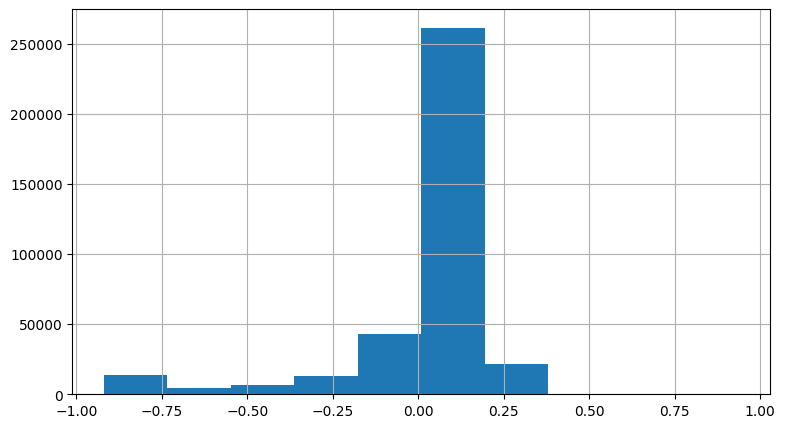

In [10]:
#universe = universe.loc[universe.index<='2023-05-25 23:00:00']
universe['alpha_atr'].hist()

### 构造评估数据

In [7]:
all_factors = universe.copy(deep=True)
def return_handle(df):
    df['returns_2'] = df['log-ret'].shift(-1)
    return df
all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['date', 'ts_code'])
print(universe.shape, all_factors.shape)

(363909, 69) (363909, 70)


In [8]:
def keep_top_bottom(df, features, bottom=0.35, top=0.65):
    def cal_(data):
        for feature in features:
            tv = data[feature].quantile(top)
            bv = data[feature].quantile(bottom)
            data[feature] = pd.Series(np.where(data[feature]>=tv, data[feature], 
                                               np.where(data[feature]<=bv, data[feature], 0)), index=data.index)
        return data
    
    all_df = pd.DataFrame()
    for dt in tqdm(df.index.unique()):
        tmp = df.loc[df.index == dt]
        all_df = all_df.append(cal_(tmp))
    return all_df.sort_values(by=['date', 'ts_code'])


def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.2, 0.2)
    #all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in factor_names:
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

In [9]:
alpha_field  = [
        'alpha_kama2','alpha_atr', 'alpha_wt', 'alpha_wtr', 'alpha_cci', 'alpha_srsi','alpha_rsi', 
        'alpha_ppo', 'alpha_supertrend', 'alpha_kama', 'alpha_t1', 'alpha_t2', 'alpha_t3', 'alpha_t4',
        'alpha_026', 'alpha_007', 'alpha_009', 'alpha_010', 'alpha_077', 'alpha_101', 'alpha_111',
        'alpha_012', 'alpha_015', 'alpha_016', 'alpha_017', 'alpha_018',
        'alpha_019', 'alpha_021', 'alpha_029', 'alpha_022', 'alpha_028',
        'alpha_044', 'alpha_078', 'alpha_083', 'alpha_112', 'alpha_040',
        'alpha_089', 'alpha_110', 'alpha_122', 'alpha_176', 'alpha_190'    
]

base_field = ['ts_code', 'log-ret', 'open', 'high', 'low', 'close', 'volume', 'vwap','trade_date']
date_and_code = [ 'ts_code', 'returns_2']

start_time = '2022-03-10 00:00:00'
alpha_df = all_factors[factor_names + date_and_code].copy(deep=True)
alpha_df = alpha_df.loc[alpha_df.index>=start_time]
calendar = alpha_df.index.unique() # int64

alpha_df = keep_top_bottom(alpha_df, alpha_field)

100%|█████████████████████████████████████| 10607/10607 [21:23<00:00,  8.26it/s]


<AxesSubplot:>

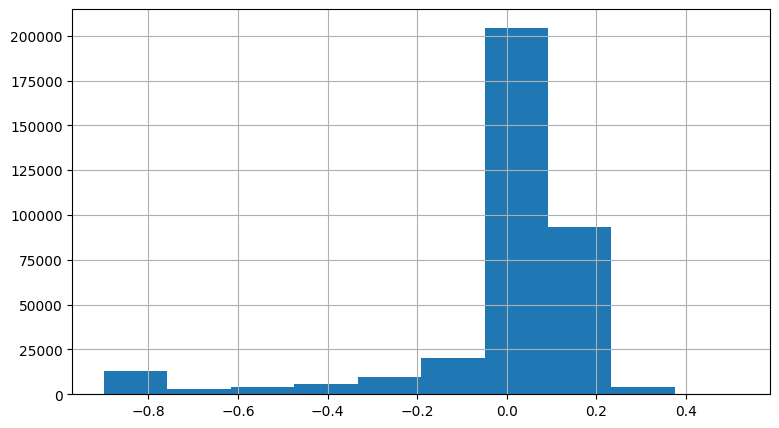

In [15]:
alpha_df['alpha_atr'].hist()

### 方法1
线性回归评估

In [ ]:
### ols to estimate 
facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[alpha_df.index==dt])

In [ ]:
### plot
date_list = alpha_df.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]

for column in facret_df.columns:
    plt.plot(facret_df[column].cumsum(), label=column)
    #plt.plot(facret_df[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

### 方法2
归一化回报率评估

In [12]:
leverage = 5
df = pd.DataFrame(index=alpha_df.index.unique())
for dt in tqdm(alpha_df.index.unique()):
    for feature in alpha_field:
        tmp = alpha_df.loc[alpha_df.index == dt]
        df.at[dt, feature] = (tmp['returns_2'] * tmp[feature]).sum()/(tmp[feature].abs().sum()) * leverage

100%|█████████████████████████████████████| 10607/10607 [14:20<00:00, 12.33it/s]


<AxesSubplot:xlabel='date'>

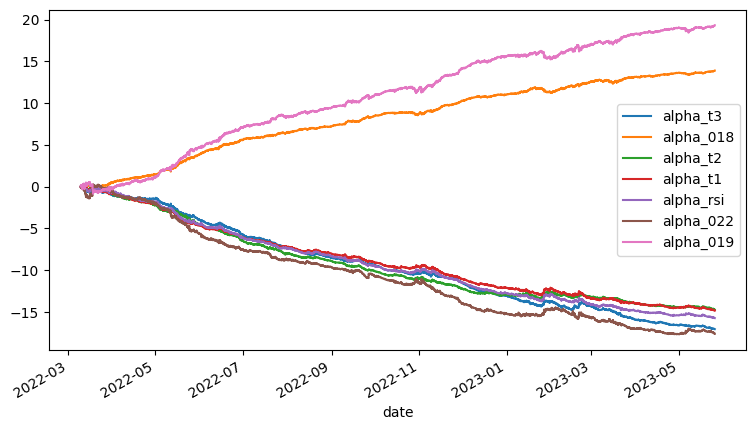

In [43]:
### plot
## atr need bias 0.2
## excellent negative 'alpha_022', 'alpha_019', 'alpha_rsi', 'alpha_cci', 'alpha_srsi', 'alpha_wt', 
##                    'alpha_t1', 'alpha_t2', 'alpha_t3', 'alpha_021', 'alpha_022', 'alpha_078', 

## excellent positive 'alpha_019', 'alpha_018', 'alpha_111', 'alpha_040',

nagative_field = ['alpha_rsi', 'alpha_cci', 'alpha_srsi', 'alpha_wt', 'alpha_t1', 'alpha_t2', 'alpha_t3',
                 'alpha_022', 'alpha_029', 'alpha_028', 'alpha_021', 'alpha_078', 'alpha_112', 'alpha_028']
positive_filed = ['alpha_t4', 'alpha_111', 'alpha_012', 'alpha_018', 'alpha_019', 'alpha_040', 'alpha_190']

display_field  = ['alpha_t3', 'alpha_018', 'alpha_t2', 'alpha_t1', 'alpha_rsi', 'alpha_022', 'alpha_019', ]
df[display_field].cumsum().plot()

In [45]:
# sharp ratio
np.sqrt(12*252) * df[display_field].mean()/ df[display_field].std()

alpha_t3    -4.982482
alpha_018    4.729542
alpha_t2    -4.622000
alpha_t1    -4.147482
alpha_rsi   -4.363981
alpha_022   -3.158332
alpha_019    3.429009
dtype: float64

### 方法3
alphalens estimate

In [ ]:
universe = universe.sort_values(by=['date','ts_code'])
universe_est = universe.copy(deep=True)
universe_est.index.unique()

In [ ]:
# dates = pd.date_range(end=pd.to_datetime('2023-03-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 
#                       periods=len(universe_est.index.unique()), freq='D')
dates = pd.date_range(end=pd.Timestamp('2023-03-28 00:00:00'), 
                      periods=len(universe_est.index.unique()), freq='D')
dates

In [ ]:
df = pd.DataFrame()
for ts_code in universe_est.ts_code.unique():
    tmp = universe_est.loc[universe_est.ts_code==ts_code]
    tmp['fake_date'] = dates[(len(universe_est.index.unique()) - tmp.shape[0]):]
    df = df.append(tmp)
df = df.sort_values(by=['date','ts_code'])

In [ ]:
#factor_names = ['alpha_078', 'alpha_019','alpha_022', 'alpha_AI', 'returns_2', 'residual']
all_factors = df.copy(deep=True)\
            [factor_names + ['fake_date','ts_code','close', 'log-ret']]
all_factors.reset_index(drop=True, inplace=True)
#all_factors['date'] = pd.to_datetime(all_factors['fake_date'], format='%Y-%m-%d')
all_factors['date'] = all_factors['fake_date'].apply(lambda x: pd.Timestamp(x))
all_factors = all_factors.set_index(['date','ts_code']).sort_values(by=['date', 'ts_code'])
print(all_factors.shape)

In [ ]:
import alphalens as al
from scipy.stats import zscore
import helper.project_helper as ph

shift_day = -1
tmp = df.copy(deep=True)
tmp['close'] = tmp.groupby('ts_code')['close'].shift(shift_day)
all_pricing = tmp.reset_index().pivot(index='fake_date', columns='ts_code', values='close')
#all_pricing = all_pricing.loc[all_pricing.index[::5]]

def show_sample_results(factors_with_alpha, features, pricing=all_pricing, holding_time=1):
    factors_with_alpha = factors_with_alpha[features]
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha, pricing, holding_time=holding_time)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = np.sqrt(252 * 12) * factor_returns.mean() / factor_returns.std()
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)
    
    qr_factor_returns = pd.DataFrame()
    for factor, factor_data in factor_data.items():
        qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0]

    (10000*qr_factor_returns).plot.bar(
        subplots=True,
        sharey=True,
        layout=(8,2),
        figsize=(12, 8),
        legend=False)

#all_pricing.head()

In [ ]:
features = [
       #'alpha_wtr', 'alpha_ppo', 'alpha_112',  'alpha_kama2',  'alpha_028', 'alpha_083', 'alpha_rsi',
        'alpha_028',
        ]
cond1 = all_factors['fake_date']>'2008-08-01'
cond2 = all_factors['fake_date']<'2023-03-30'
eva_df = all_factors.loc[cond1 & cond2]
show_sample_results(eva_df, features, pricing=all_pricing, holding_time=1)

In [ ]:
test = all_factors.loc[all_factors.index.get_level_values(0)>'2016-04-01']
factor_data = ph.build_factor_data(test[['alpha_028', 'alpha_ppo', 'alpha_112']], 
                                   all_pricing, holding_time=6)
#al.tears.create_returns_tear_sheet(factor_data['alpha_atr'], long_short=False, group_neutral=False, by_group=False)

In [ ]:
al.tears.create_information_tear_sheet(factor_data['alpha_028'])

### save result

In [ ]:
features = ['ts_code', 'log-ret', 'open', 'high', 'low', 'close', 'volume',  'vwap','trade_date', 
           'alpha_wtr', 'alpha_ppo', 'alpha_112',  'alpha_kama2',  'alpha_028', 'alpha_083', 'alpha_rsi',
           ]

save_date = universe.loc[universe.index>='2022-02-01 00:00:00']
save_date[features].reset_index().to_feather('bitcoin_data/36_zscore.feather')

In [ ]:
save_date[features].index.unique()